# Klasifikace obrázků CIFAR-10 pomocí vícevrstvého perceptronu

Úkolem cvičení je natrénovat vícevrstvý perceptron pro klasifikaci na datasetu CIFAR-10 s alespoň 50% úpěšností na validační sadě.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '11.0.0'
os.environ['HIP_LAUNCH_BLOCKING'] = '1'

%env

{'PATH': '/home/rob/Programming/Bakalarka_IdentifikaceAutoraTextu/venv/bin:/home/rob/.cargo/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/bin:/usr/lib/llvm/17/bin:/usr/lib/llvm/16/bin:/etc/eselect/wine/bin:/home/rob/.local/share/JetBrains/Toolbox/scripts',
 'XAUTHORITY': '/tmp/xauth_MmLNJP',
 'XDG_DATA_DIRS': '/usr/local/share:/usr/share:/etc/eselect/wine/share',
 'MOTD_SHOWN': 'pam',
 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/tmp/dbus-8LkpqiPLMt,guid=5a9c355febe3d012291db564659991bf',
 'PS1': '(venv) ',
 'XDG_CURRENT_DESKTOP': 'KDE',
 'QT_AUTO_SCREEN_SCALE_FACTOR': '0',
 'MAIL': '/var/mail/rob',
 'LADSPA_PATH': '/usr/lib64/ladspa',
 'SESSION_MANAGER': 'local/genchuu:@/tmp/.ICE-unix/3124,unix/genchuu:/tmp/.ICE-unix/3124',
 'LOGNAME': 'rob',
 'JDK_HOME': '/etc/java-config-2/current-system-vm',
 'PAM_KWALLET5_LOGIN': '/run/user/1000/kwallet5.socket',
 'PWD': '/home/rob/Programming/ans-2023',
 'INFOPATH': '/usr/share/gcc-data/x86_64-pc-linux-gnu/13/info:/usr/share/bi

In [3]:
import sys
sys.path.append('..')  # import tests

import torch
import torchvision

import ans
from tests import test_multilayer_perceptron
from tests import randn_var

/home/rob/Programming/Bakalarka_IdentifikaceAutoraTextu/venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Třída `ans.optim.Optimizer`

 Ve cvičení [neural-library](neural-library.ipynb) jsme navrhli vrstvy sítě jako objekty, které je možné libovolně skládat za sebou použitím třídy `Sequential`. Jednoduchý model zadefinujeme např. takto:

In [4]:
model = ans.modules.Sequential(
    ans.modules.Linear(4, 4),
    ans.modules.Sigmoid(),
    ans.modules.Linear(4, 3),
    ans.modules.Sigmoid(),
    ans.modules.Linear(3, 2)
)
model

Seznam parametrů získáme metodou `named_parameters()`.

In [5]:
model.named_parameters()

[('0.bias', Variable(shape=(4,), grad_fn=None)),
 ('0.weight', Variable(shape=(4, 4), grad_fn=None)),
 ('2.bias', Variable(shape=(3,), grad_fn=None)),
 ('2.weight', Variable(shape=(4, 3), grad_fn=None)),
 ('4.bias', Variable(shape=(2,), grad_fn=None)),
 ('4.weight', Variable(shape=(3, 2), grad_fn=None))]

Trénování sítě bude spočívat v aktualizaci atributů `p.data` pomocí `p.grad` každého parametru `p`.
``` python
for name, par in model.named_parameters():
    par.data -= 1e-3 * par.grad  # SGD update with learning rate of 0.001
```

Uvedený kód implementuje update parametru `par` stochastickou metodou největšího spádu (Stochastic Gradient Descent, SGD). Proměnná `par` ve `for` cyklu je odkazem na objekt typu `Variable`, který jako svůj atribut drží jedna z vrstev modelu a používá ho např. při dopředném průchodu. Jelikož vedle SGD existují i jiné metody optimalizace parametrů, je vhodné kód výše refaktorovat do objektů tak, aby výměna SGD nař. za [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) byla otázkou max. jednoho řádku kódu. Zavedeme proto speciální modul `ans.optim`, který bude obsahovat optimalizační algoritmy, a v něm zadefinujeme základní třídu `Optimizer`, jež bude sloužit jako (abstraktní) vzorové rozhraní optimalizace.

In [6]:
ans.optim.Optimizer??

Metoda `__init__` třídy `Optimizer` převezme seznam parametrů modelu. Ten získáme např. jako `model.parameters()`. Metoda `parameters` je implementována v základní tříde `ans.modules.Module` a funguje podobně jako `named_parameters` - pouze výsledek vrací bez automaticky vygenerovaných jmen.

Metoda `step` bude pro každý optimizér jiná a bude implementovat nějaké konkrétní pravidlo updatu parametrů. V případě SGD půjde o kód uvedený výše.

Metoda `zero_grad` u všech parametrů, které má optimizér zaregistrovány ve svém atributu `self.parameters`, vynuluje atribut `grad` jeho nastavením na `None`. Metodu `zero_grad` bude nutné volat vždy před spuštěním zpětné propagace, jinak dojde k akumulaci gradientů např. z minulé dávky.

# (Momentum) Stochastic Gradient Descent (SGD)

Základní metodou optimalizace je stochastická metoda největšího spádu (Stochastic Gradient Descent, SGD). Po vzoru knihovny PyTorch budeme implementovat verzi s "hybností", tzv. Momentum SGD.

**Jeden krok optimalizace**

$$
\begin{split}
    % v^{(t)} & := \alpha \cdot v^{(t-1)} - \gamma \cdot \nabla l\left( v^{(t-1)} \right) \\
    % v^{(t+1)} & := \alpha \cdot v^{(t)} - \gamma \cdot \overline{\theta}} \\
    % \theta^{(t+1)} & := \theta^{(t)} + v^{(t+1)}
    \widehat{\theta}_{t} & := \overline{\theta}_t + \lambda \cdot \theta_{t} \\
    v_{t} & := \alpha \cdot v_{t-1} - \gamma \cdot \widehat{\theta}_{t} \\
    \theta_{t+1} & := \theta_{t} + v_t
\end{split}
$$
- všechny proměnné jsou reálná čísla (skaláry)
- $\theta_{t}$ a $\theta_{t+1}$ značí původní, resp. nově vypočtenou hodnotu jednoho z parametrů modelu (např. jednoho z prvků váhové matice)
<!-- - $\theta_{t}$ značí novou hodnotu parametru po provedení updatu metodou SGD -->
- $\overline{\theta}_t = \partial l_t / \partial \theta_{t}$ je gradient celkového lossu $l_t$ v iteraci $t$ vůči parametru $\theta_{t}$ získaný zpětnou propagací
- $\widehat{\theta}_{t}$ je upravený gradient se zohledněním regularizace
- $v_{t-1}$ a $v_t$ značí "rychlosti" (velocity) z minulého, resp. aktuálního kroku
- $\alpha \in [0, 1]$ (hyperparametr) je reálné číslo mezi 0 a 1 (včetně) a značí tzv. hybnost (momentum)
- $\lambda$ (hyperparametr) je koeficient L2 regularizace, tzv. weight decay
- $\gamma$ (hyperparametr) značí krok učení, tzv. learning rate

Krok bude implementovat metoda `step` třídy `SGD`. Projde všechny registrované parametry (proměnné typu `ans.autograd.Variable`) a *pokud obsahují `grad`, který není `None`*, dojde k updatu jejich atributu `data` uvedeným pravidlem. Atributy, jejichž `grad` je `None`, se z updatu vynechají.

### TODO: implementujte třídu `SGD` v modulu `ans.optim`

In [7]:
test_multilayer_perceptron.TestSGD.eval()

test_init (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_init) ... ok
test_momentum (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_momentum) ... ok
test_sgd (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_sgd) ... ok
test_weight_decay (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_weight_decay) ... ok
test_weight_decay_momentum (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_weight_decay_momentum) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.034s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

# Načtení dat a příprava dat

Kód pro načítání a zpracování dat bude velmi podobný cvičení [Lineární klasifikace](linear-classification.ipynb).

In [8]:
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train

In [9]:
val_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
val_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

Rozdíl bude ve funkci `preprocess`, která nyní bude zařizovat i konverzi do správného datového typu. Trénování je pak možné přepnutím jediného řádku díky podpoře v PyTorchi spustit i na grafické kartě, viz hlavní cyklus. V důsledku je tak nutné do `preprocess` posílat i `targets`, protože při výpočtech musejí být všechny tensory na stejném zařízení. Tensoru `targets` se to týká při výpočtu křížové entropie. Funkce pak bude vracet dvojici `(outputs, targets)`.

In [25]:
def preprocess(
        inputs: torch.Tensor,
        targets: torch.Tensor,
        dtype: torch.dtype = torch.float32,
        device: torch.device = torch.device(type='cpu')
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Args:
        inputs: n-dimensional tensor with first dimension of size num_inputs
        targets: 1-dimensional tensor (vector) with first dimension of size num_inputs
        dtype: to which data type should the inputs (not targets) be converted
        device: to which device should both inputs and targets be transferred
    Returns:
        outputs: 2-dimensional tensor; shape (num_inputs, num_features), dtype `dtype`, device `device`
        targets: 1-dimensional tensor (vector); shape (num_inputs,1) device `device`
    """
    
    ########################################
    # TODO: implement

    inputs = inputs / 255
    outputs = inputs.reshape(inputs.shape[0], -1).to(dtype=dtype,device=device) - 0.5
    #targets = targets.to(device='cuda')
    #outputs = outputs.to(device='cuda')
    
    # ENDTODO
    ########################################
    
    return outputs, targets

In [11]:
print(os.environ['HSA_OVERRIDE_GFX_VERSION'])
test_multilayer_perceptron.TestPreprocess.eval(preprocess_fn=preprocess)

test_device (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_device) ... 

11.0.0


ok
test_dtype (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_dtype) ... ok
test_values (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_values) ... ok

----------------------------------------------------------------------
Ran 3 tests in 1.722s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Funkce pro trénování

In [12]:
def accuracy(scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Args:
        scores: output linear scores (logits before softmax); shape (num_samples, num_classes)
        targets: vector of class indicies (integers); shape (num_samples,)
    Returns:
        acc: averare accuracy on the batch; tensor containing single number (scalar), e.g. "tensor(0.364)"
    """
    
    ########################################
    # TODO: implement

    acc = torch.sum((scores.argmax(1)==targets))/targets.shape[0]
    
    # ENDTODO
    ########################################
    
    return acc

In [13]:
test_multilayer_perceptron.TestAccuracy.eval(accuracy_fn=accuracy)

test_accuracy (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_accuracy) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

Ve funkcích `train_step` a `val_step` předejte do `preprocess` zařízení a datový typ modelu. Získáte je jako `model.device()`, resp. `model.dtype()`. Nezapomeňte také na `zero_grad()`.

In [20]:
def train_step(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    model: ans.modules.Module,
    criterion: ans.modules.Module,
    optimizer: ans.optim.Optimizer
) -> tuple[float, float]:
    ########################################
    # TODO: implement

    # set model.device to cuda if avaible
    #if torch.cuda.is_available():
    #   model.to(device='cuda')

    optimizer.zero_grad()
    inputs, targets = preprocess(inputs, targets,dtype=model.dtype(),device=model.device())
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backprop()
    optimizer.step()
    acc = accuracy(output.data, targets)
    
    # ENDTODO
    ########################################
    
    return loss.data.item(), acc.item()

In [23]:
def val_step(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    model: ans.modules.Module,
    criterion: ans.modules.Module
) -> tuple[float, float]:
    ########################################
    # TODO: implement

    # set model.device to cuda if avaible
    #if torch.cuda.is_available():
    #   model.to(device='cuda')

    inputs, targets = preprocess(inputs, targets,dtype=model.dtype(),device=model.device())
    output = model(inputs)
    loss = criterion(output, targets)
    acc = accuracy(output.data, targets)
    
    # ENDTODO
    ########################################
    
    return loss.data.item(), acc.item()

In [26]:
test_multilayer_perceptron.TestSteps.eval(train_step_fn=train_step, val_step_fn=val_step)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_train_step (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_train_step) ... ok
test_val_step (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_val_step) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.058s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [27]:
def validate(
    loader: ans.data.BatchLoader,
    model: ans.modules.Module,
    criterion: ans.modules.Module
) -> tuple[float, float]:
    total_loss = 0.
    total_acc = 0.
    for inputs, targets in loader:
        loss, acc = val_step(inputs, targets, model, criterion)
        total_loss += loss
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

# Hlavní cyklus

### TODO: Natrénujte MLP model dosahující alespoň 50% úspěšnosti na validační sadě.

In [43]:
%%time


# test rocm
import torch
print(torch.__version__)
print(torch.version.hip)
print(torch.cuda.is_available())


# reproducibility
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 60
batch_size = 256
learning_rate = 1e-4
momentum = 0.95
weight_decay = 1e-7

# data loaders
train_loader = ans.data.BatchLoader(
    torch.tensor(train_dataset.data),
    torch.tensor(train_dataset.targets),
    batch_size=batch_size,
    shuffle=True
)
val_loader = ans.data.BatchLoader(
    torch.tensor(val_dataset.data),
    torch.tensor(val_dataset.targets),
    batch_size=batch_size,
    shuffle=False
)

n_targets = len(set(train_dataset.targets))
img_size = train_dataset.data[0].size

model = ans.modules.Sequential(
    ans.modules.Linear(img_size,batch_size),
    ans.modules.ReLU(),
    ans.modules.Linear(batch_size,batch_size),
    ans.modules.Dropout(p=0.3),
    ans.modules.BatchNorm1d(batch_size),
    ans.modules.ReLU(),
    ans.modules.Linear(batch_size, n_targets),
)


#model.to(device='cuda')  # optionally run on the GPU

#print(model.device())

# loss function
criterion = ans.modules.SoftmaxCrossEntropy()

# optimizer
optimizer = ans.optim.SGD(
    model.parameters(),
    learning_rate=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay
)

# validate once before training
train_loss, train_acc = validate(train_loader, model, criterion)
val_loss, val_acc = validate(val_loader, model, criterion)

# record history for plotting
history = ans.utils.MetricsHistory()
history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

# optimize
for epoch in range(num_epochs):
    # train loop
    model.train()
    for inputs, targets in train_loader:
        loss, acc = train_step(inputs, targets, model, criterion, optimizer)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc

    # validation loop
    model.eval()
    val_loss, val_acc = validate(val_loader, model, criterion)

    history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

       train_loss  train_acc  val_loss   val_acc
epoch                                           
0        2.380266   0.101993  2.385335  0.099512
1        2.124960   0.234752  1.980403  0.321777
2        1.947107   0.322070  1.866672  0.367188
3        1.847672   0.362000  1.798616  0.382520
4        1.786035   0.384032  1.748528  0.396582
...           ...        ...       ...       ...
56       1.046252   0.641760  1.318072  0.530664
57       1.036960   0.643705  1.322326  0.531445
58       1.029303   0.648368  1.318318  0.529492
59       1.021467   0.652751  1.320371  0.529590
60       1.007456   0.658698  1.316831  0.534668

[61 rows x 4 columns]
CPU times: user 19min 50s, sys: 2.05 s, total: 19min 52s
Wall time: 2min 29s


train_loss    1.222049
train_acc     0.576644
val_loss      1.366427
val_acc       0.517405
Name: 30, dtype: float64


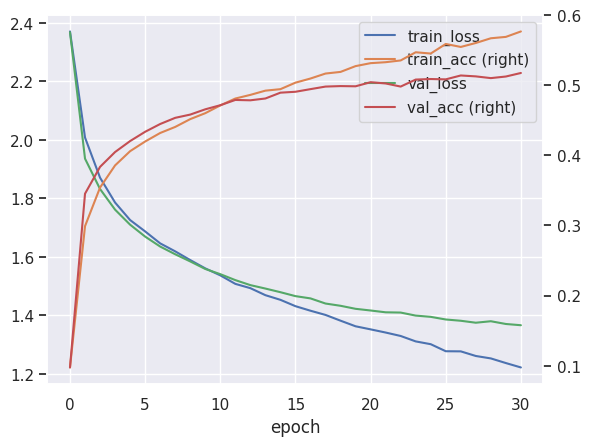

In [29]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

# Další vylepšení

Jako bonus můžete zkusit trochu vylepšit skóre sítě několika technikami. Implementujte postupně každou z nich, opakujte hlavní cyklus znovu a sledujte, zda a jak se mění výsledná přesnost na validační sadě (`val_acc`). Model by měl dosáhnout alespoň 55% přesnosti na validační množině. Výsledku lze navíc dosáhnout rychleji, tj. dříve a s menším počtem epoch.

## Preprocessing

Jako nejjednodušší vylepšení můžete zkusit vycentrovat data, která vstupují do sítě, tak, aby měla přibližně nulový průměr. Není nutné počítat průměr dávky či z celého datasetu. Od každé dávky znormalizované do rozsahu 0...1 jednoduše odečtěte 0.5.

### TODO: modifikujte funkci `preprocess` tak, aby prvky výstupu měly přibližně nulovou očekávanou hodnotu

In [30]:
test_multilayer_perceptron.TestPreprocess.eval(preprocess_fn=preprocess, centered=True)

test_device (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_device) ... FAIL
test_dtype (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_dtype) ... ok
test_values (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_values) ... FAIL

FAIL: test_device (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_device)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/rob/Programming/ans-2023/tests/test_multilayer_perceptron.py", line 109, in test_device
    self.assertEqual(y.device, device)
AssertionError: device(type='cpu') != device(type='cuda', index=0)

FAIL: test_values (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_values)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/rob/Programming/ans-2023/tests/test_multilayer_perceptron.py", line 89, in test_values
    raise e
  File "/home/rob/Programming/ans-2023/tests/test_multilayer_perc

<unittest.runner.TextTestResult run=3 errors=0 failures=2>

In [ ]:
# main loop

train_loss    1.222049
train_acc     0.576644
val_loss      1.366427
val_acc       0.517405
Name: 30, dtype: float64


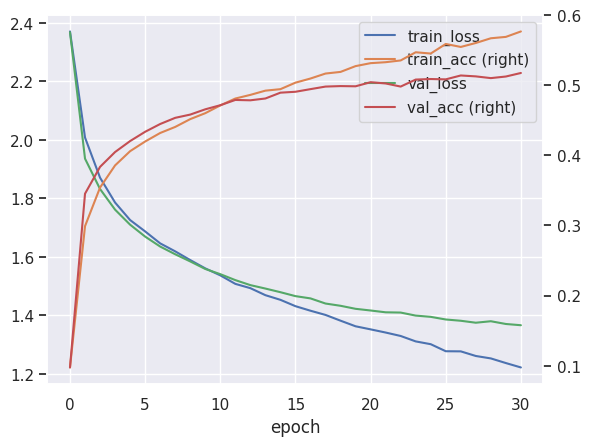

In [31]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Rectified Linear Unit (ReLU)

Sigmoid nelinearita nemá příliš vhodné vlastnosti pro zpětnou propagaci. Efektivnější se z tohoto pohledu se ukázala rektifikovaná lineární jednotka, tzv. ReLU.

**Dopředný průchod**

$$
z = \begin{cases}
    0 & \textrm{pokud} & x \le 0 \\
    x & \textrm{pokud} & x \gt 0 \\
\end{cases}
$$
- $x$ je reálné číslo (skalár)
- $z$ je reálně číslo (skalár)

**Zpětný průchod**

$$
\overline{x} = \begin{cases}
    0 & \textrm{pokud} & x \le 0 \\
    \overline{z} & \textrm{pokud} & x \gt 0 \\
\end{cases}
$$
- $\overline{z}$ je příchozí gradient na $z$

**Dávkové zpracování**

Operaci ReLU aplikujeme na všechny prvky vstupu nezávisle na sobě.

**Poznámka**

Jelikož operace ReLU není diferencovatelná, numerický gradient se pro malé hodnoty $x \approx 0$ kolem bodu zlomu v nule nechová jako subgradient a nevychází "správně". Pokud vám `gradcheck` v testu selže i přes podle vás správnou implementaci zpětného průchodu, zkuste ho opakovat. Pravděpodobnost selhávajícího testu je cca 27 %.

### TODO: implementujte funkci `ans.functional.ReLU` a vrstvu `ans.modules.ReLU`

In [33]:
ans.autograd.gradcheck(
    ans.functional.ReLU.apply,
    (
        randn_var(8, 4, std=10., name='input'),
    )
)

dinput ok: rel_err=1.489e-14, abs_err=2.287e-14


True

In [34]:
test_multilayer_perceptron.TestReLU.eval()

test_forward_function (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function) ... ok
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.015s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [ ]:
# main loop

train_loss    1.222049
train_acc     0.576644
val_loss      1.366427
val_acc       0.517405
Name: 30, dtype: float64


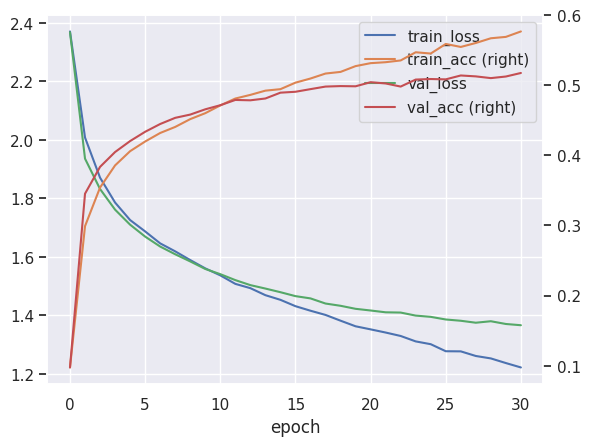

In [35]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Normalizace dávky (batch normalization)

Další vylepšení úspěšnosti je možné dosáhnout normalizací výstupů skrytých vrstev, tzv. batch normalizací.

**Dopředný průchod v trénovacím režimu**

$$
\begin{split}
    \boldsymbol{\mu} & = \frac{1}{N}\sum_{n=1}^N{\boldsymbol{x}_n} \\
    \boldsymbol{\sigma}^2 & = \frac{1}{N}\sum_{n=1}^N{\left(\boldsymbol{x}_n - \boldsymbol{\mu}\right)^2} \\
    \widehat{\boldsymbol{x}}_n & = \frac{\boldsymbol{x}_n - \boldsymbol{\mu}}{\sqrt{\boldsymbol{\sigma}^2 + \epsilon}} \\
    \boldsymbol{z}_n & = \boldsymbol{\gamma} \odot \widehat{\boldsymbol{x}}_n + \boldsymbol{\beta}
\end{split}
$$
- $\boldsymbol{x}_n = [x_{n1}, \ldots, x_{nD}]$ je jeden vzorek dávky jako (řádkový) vektor s rozměrem $D$
- $N$ je počet vstupů (vektorů) v dávce
- $\boldsymbol{\mu} = [\mu_1, \ldots, \mu_D]$ je odhad průměrného vektoru na základě dávky
- $\boldsymbol{\sigma}^2 = [\sigma_1^2, \ldots, \sigma_D^2]$ *vychýlený* odhad vektoru rozptylů na základě dávky
- $\boldsymbol{\gamma} = [\gamma_1, \ldots, \gamma_D]$ je (řádkový) vektor s rozměrem $D$ škálující standardní odchylku výstupu
- $\boldsymbol{\beta} = [\beta_1, \ldots, \beta_D]$ je (řádkový) vektor s rozměrem $D$ posouvající očekávanou hodnotu výstupu
- $\epsilon \approx 10^{-5}$ je konstanta (reálné číslo) zabraňující dělení nulou
- $\boldsymbol{z}_n = [z_1, \ldots, z_D]$ je (řádkový) výstupní vektor s rozměrem $D$

V trénovacím režimu zároveň průběžně akumulujeme statistiky průměrného vektoru a vektoru rozptylů

$$
\begin{split}
    \boldsymbol{m} & := \alpha \cdot \boldsymbol{m} + (1 - \alpha) \cdot \boldsymbol{\mu} \\
    \boldsymbol{v}^2 & := \alpha \cdot \boldsymbol{v}^2 + (1 - \alpha) \cdot \frac{N}{N-1} \cdot \boldsymbol{\sigma^2}
\end{split}
$$
- $\boldsymbol{m} = [m_1, \ldots, m_D]$ je průběžný odhad očekávaného vektoru $\boldsymbol{\mu}$, tj. $\boldsymbol{m} \approx E[\boldsymbol{\mu}]$
- $\boldsymbol{v}^2 = [v_1^2, \ldots, v_D^2]$ je průběžný *nevychýlený* odhad očekávaného vektoru $\boldsymbol{\sigma^2}$, tj. $\boldsymbol{v}^2 \approx E[\boldsymbol{\sigma^2}]$
- $\alpha$ je vyhlazovací koeficient (reálné číslo) pamatování při odhadu průběžného průměru a rozptylu
- $N / (N - 1)$ je tzv. Besselova korekce, viz pozn. Odhad rozptylu

**Zpětný průchod**
$$
\begin{split}
    \overline{\boldsymbol{x}}_n & = 
        \frac{\boldsymbol{\gamma}}{\sqrt{\boldsymbol{\sigma}^2 + \epsilon}} \odot \left(
            \overline{\boldsymbol{z}}_n
            - \frac{1}{N}\sum_{i=1}^N{\overline{\boldsymbol{z}}_i}
            - \frac{1}{N} \widehat{\boldsymbol{x}}_n \odot \sum_{i=1}^N{\overline{\boldsymbol{z}}_i\odot\widehat{\boldsymbol{x}}_i}
        \right) \\
    \overline{\boldsymbol{\gamma}} & = \sum_{n=1}^N{ \overline{\boldsymbol{z}}_n \odot \widehat{\boldsymbol{x}}_n } \\
    \overline{\boldsymbol{\beta}} & =\sum_{n=1}^N{ \overline{\boldsymbol{z}}_n }
\end{split}
$$
- $\overline{\boldsymbol{z}}_n = [\overline{y}_{n1}, \ldots, \overline{z}_{nD}]$ je příchozí gradient na výstup $\boldsymbol{z}_n$ jako (řádkový) vektor s rozměrem $D$
- $\overline{\boldsymbol{x}}_n = [\overline{x}_{n1}, \ldots, \overline{x}_{nD}]$ je výsledný odchozí gradient na vstup $\boldsymbol{x}_n$ jako (řádkový) vektor s rozměrem $D$
- $\overline{\boldsymbol{\gamma}} = [\overline{\gamma}_1, \ldots, \overline{\gamma}_D]$ je výsledný odchozí gradient na $\boldsymbol{\gamma}$ jako vektor s rozměrem $D$
- $\overline{\boldsymbol{\beta}} = [\overline{\beta}_1, \ldots, \overline{\beta}_D]$ je výsledný odchozí gradient na $\boldsymbol{\beta}$ jako vektor s rozměrem $D$

**Dopředný průchod v testovacím režimu**

V testovacím režimu nepočítáme statistiky z dávky, ale použijeme odhady $\boldsymbol{m}$ a $\boldsymbol{v}^2$ z trénovací fáze. Zároveň nedochází k jejich aktualizaci.
$$
\begin{split}
    \widehat{\boldsymbol{x}}_n & = \frac{\boldsymbol{x}_n - \boldsymbol{m}}{\sqrt{\boldsymbol{v}^2 + \epsilon}} \\
    \boldsymbol{z}_n & = \boldsymbol{\gamma} \odot \widehat{\boldsymbol{x}}_n + \boldsymbol{\beta}
\end{split}
$$

**Zpětný průchod v testovacím režimu**
$$
\overline{\boldsymbol{x}}_n = \frac{\boldsymbol{\gamma}}{\sqrt{\boldsymbol{\sigma}^2 + \epsilon}} \odot \overline{\boldsymbol{z}}_n
$$

**Odhad rozptylu**

V PyTorchi pozor na odhad rozptylu metodou `var`. Ve výchozím režimu počítá tzv. nevychýlený odhad, kdy se namísto $1/N$ dělí $1/(N-1)$, viz [Besselova korekce](https://en.wikipedia.org/wiki/Bessel%27s_correction). Batch normalizace ale přitom používá vychýlený odhad $\boldsymbol{\sigma}^2$ a do funkce [torch.var](https://pytorch.org/docs/stable/generated/torch.var.html) je proto nutné explicitně zadat `unbiased=False`.

Při výpočtu průběžného rozptylu $\boldsymbol{v^2}$ Pytorch přenásobí odhad $\boldsymbol{\sigma}^2$ zmíněnou Besselovou korekcí $N / (N - 1)$. Nejedná se o nekonzistentní chování ani chybu. Důvod je ten,  že $\boldsymbol{v^2}$ se snaží odhadovat skutečný očekávaný rozptyl dávky, tzn. $\boldsymbol{v}^2 \approx E[\boldsymbol{\sigma^2}]$, a ten je nejpřesnější jako nevychýlený.

Dokumentace Pytorch verze 1.13.0 obsahuje neúplné informace, viz [https://github.com/pytorch/pytorch/issues/77427](https://github.com/pytorch/pytorch/issues/77427).

### TODO: implementujte funkci `ans.functional.BatchNorm1d` a vrstvu `ans.modules.BatchNorm1d`

In [36]:
ans.autograd.gradcheck(
    ans.functional.BatchNorm1d.apply,
    (
        randn_var(8, 4, mean=1., std=2., name='input'),
        randn_var(4, name='gamma'),
        randn_var(4, name='beta')
    ),
    params=dict(training=True)
)

dinput ok: rel_err=2.021e-05, abs_err=7.808e-06
dgamma ok: rel_err=1.657e-14, abs_err=2.842e-14
dbeta ok: rel_err=2.380e-14, abs_err=2.376e-14


True

In [37]:
ans.autograd.gradcheck(
    ans.functional.BatchNorm1d.apply,
    (
        randn_var(8, 4, mean=1., std=2., name='input'),
        randn_var(4, name='gamma'),
        randn_var(4, name='beta'),
        torch.randn(4).double(),  # running_mean
        torch.rand(4).double(),  # running_var
    ),
    params=dict(training=False)
)

dinput ok: rel_err=1.509e-14, abs_err=1.155e-14
dgamma ok: rel_err=1.194e-14, abs_err=4.974e-14
dbeta ok: rel_err=1.333e-14, abs_err=3.553e-14


True

In [38]:
test_multilayer_perceptron.TestBatchNorm1d.eval()

test_forward_function_affine (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_affine) ... ok
test_forward_function_linear (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_linear) ... ok
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_output_types (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_output_types) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.043s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [ ]:
# main loop

train_loss    1.222049
train_acc     0.576644
val_loss      1.366427
val_acc       0.517405
Name: 30, dtype: float64


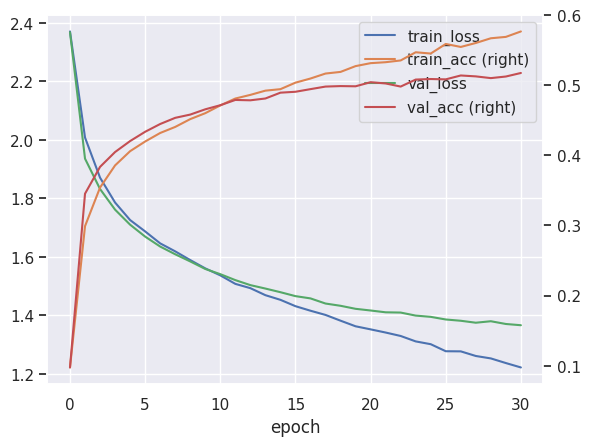

In [39]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Dropout

Vedle klasické L2 regularizace (parametr `weight_decay` v optimizéru) je možné použít i tzv. dropout. Operaci aplikujeme na všechny prvky vstupu nezávisle na sobě. Implementujeme tzv. [inverted dropout](https://stats.stackexchange.com/questions/205932/dropout-scaling-the-activation-versus-inverting-the-dropout), tedy verzi, kdy ke škálování výstupu dochází již v trénovací fázi a testovací režim se chová jako identita.

**Dopředný průchod**

$$
\begin{split}
    m & \sim \mathcal{U}\left[ 0, 1 \right] \\
    z & = \begin{cases}
        0 & \textrm{pokud} & m \lt p \\
        \frac{x}{1 - p} & \textrm{pokud} & m \ge p \\
    \end{cases}
\end{split}
$$
- $x$ je reálné číslo (skalár)
- $z$ je reálné číslo (skalár)
- $m$ je reálné číslo náhodně vybrané z intervalu $[0, 1]$
- $p$ je reálné číslo (skalár) určující pravděpodobnost, s jakou dojde k vynulování $x$

**Zpětný průchod**

$$
\overline{x} = \begin{cases}
    0 & \textrm{pokud} & m \lt p \\
    \frac{\overline{z}}{1 - p} & \textrm{pokud} & m \ge p \\
\end{cases}
$$
- $\overline{z}$ je příchozí gradient na $z$

**Dopředný průchod v testovacím režimu**

$$
z = x
$$

**Zpětný průchod v testovacím režimu**
$$
\overline{x} = \overline{z}
$$

### TODO: implementujte funkci `ans.functional.Dropout` a vrstvu `ans.modules.Dropout`

In [40]:
ans.autograd.gradcheck(
    ans.functional.Dropout.apply,
    (
        randn_var(8, 4, name='input')
    ),
    params=dict(training=True, seed=42)
)

TypeError: Dropout.forward() got multiple values for argument 'training'

In [106]:
ans.autograd.gradcheck(
    ans.functional.Dropout.apply,
    (
        randn_var(8, 4, name='input')
    ),
    params=dict(training=False, seed=42)
)

TypeError: Dropout.forward() got multiple values for argument 'training'

In [41]:
test_multilayer_perceptron.TestDropout.eval()

test_forward_function_eval (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_eval) ... ok
test_forward_function_training (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_training) ... ok
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... ok
test_forward_output_types (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_output_types) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.042s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [ ]:
# main loop

train_loss    1.222049
train_acc     0.576644
val_loss      1.366427
val_acc       0.517405
Name: 30, dtype: float64


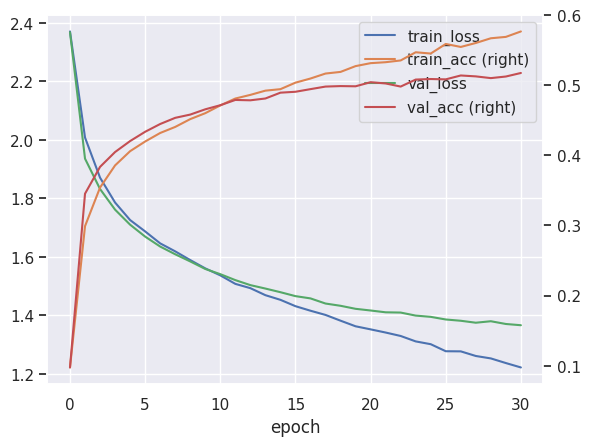

In [42]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Adaptive Momentum (Adam)

**Pravidlo updatu parametru**

$$
\begin{split}
    t & := t + 1 \\
    \widehat{\theta}_t & := \overline{\theta}_t + \lambda \cdot \theta_t \\
    m_t & := \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \widehat{\theta}_t \\
    v_t & := \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot \widehat{\theta}_t^2 \\
    \widehat{m}_t & := \frac{m_t}{1 - \beta_1^t} \\
    \widehat{v}_t & := \frac{v_t}{1 - \beta_2^t} \\
    \theta_{t} & := \theta_{t-1} - \gamma \cdot \frac{\widehat{m}_t}{\sqrt{\widehat{v}_t} + \epsilon}
\end{split}
$$
- všechny proměnné jsou reálná čísla a mají podobný význam jako u SGD
- $v$ a $u$ jsou buffery, které se mezi jednotlivými iteracemi předávají

Hyperparametry metody jsou
- learning rate $\gamma$
- weight decay $\lambda$
- alpha $\alpha \in [0, 1]$
- beta $\beta \in [0, 1]$
- epsilon $\epsilon \approx 10^{-8}$



### TODO: implementujte optimizér `ans.optim.Adam`

In [112]:
test_multilayer_perceptron.TestAdam.eval()

test_adam (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_adam) ... ok
test_init (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_init) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.013s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [ ]:
# main loop

train_loss    1.222448
train_acc     0.577089
val_loss      1.365234
val_acc       0.518888
Name: 30, dtype: float64


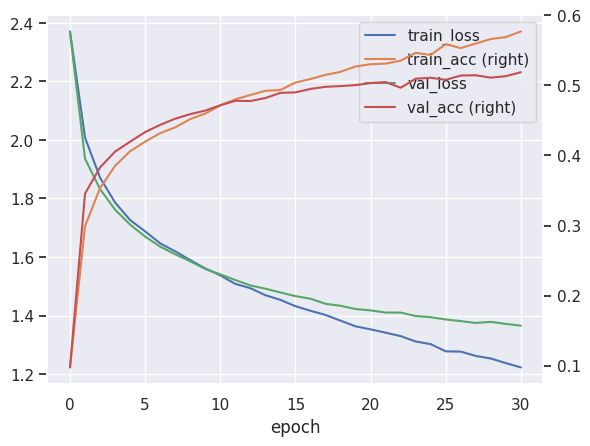

In [113]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);